In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.utils.data as Data
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [2]:
### find bugs if cuda didn't tell us where the bugs were
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

### Transformer Model

In [2]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim

        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        scores = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.hidden_dim).float())
        attention_weights = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attention_weights, v)

        return attended_values


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, max_seq_length):
        super(PositionalEncoding, self).__init__()
        self.hidden_dim = hidden_dim

        pe = torch.zeros(max_seq_length, hidden_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / hidden_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x


class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(EncoderLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.attention = Attention(hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(x + attended)
        feed_forward_output = self.feed_forward(x)
        x = self.norm2(x + feed_forward_output)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, num_heads):
        super(DecoderLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        self.attention1 = Attention(hidden_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.attention2 = Attention(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.norm3 = nn.LayerNorm(hidden_dim)

    def forward(self, x, encoder_output):
        attended1 = self.attention1(x)
        x = self.norm1(x + attended1)
        attended2 = self.attention2(x)
        x = self.norm2(x + attended2)
        feed_forward_output = self.feed_forward(x)
        x = self.norm3(x + feed_forward_output)
        return x

# Transformer
class a_Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_heads, max_seq_length):
        super(a_Transformer, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_dim + 1000, hidden_dim)
        self.position_encoding = PositionalEncoding(hidden_dim, max_seq_length)
        self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, num_heads) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(hidden_dim, num_heads) for _ in range(num_layers)])
        self.fc = nn.Linear(hidden_dim, 249)

    def forward(self, x):
        x = x.long()
        embedded = self.embedding(x)
        # print("embed:", embedded.size())
        x = self.position_encoding(embedded)

        for i in range(self.num_layers):
            x = self.encoder_layers[i](x)

        for i in range(self.num_layers):
            x = self.decoder_layers[i](x, embedded)

        x = self.fc(torch.tanh(x))
        return x

### Dataloader

In [3]:
train = np.load("./data_nature/new_cell_data.npy")
train = train[:6000,:]
label = np.load("./data_nature/label_chirp.npy")
label = label.T[:6000,:]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=0)

X_train_final = torch.from_numpy(X_train.astype(np.float32))
y_train_final = torch.from_numpy(y_train.astype(np.float32))
X_test_final = torch.from_numpy(X_test.astype(np.float32))
y_test_final = torch.from_numpy(y_test.astype(np.float32))

train_data = Data.TensorDataset(X_train_final, y_train_final)
test_data = Data.TensorDataset(X_test_final, y_test_final)
train_loader = Data.DataLoader(dataset=train_data, batch_size=16,
                               shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset=test_data, batch_size=16,
                               shuffle=True, num_workers=0)

In [5]:
input_dim = 1503 
target_dim = 249  
seq_length = 1503 
hidden_dim = 256  
num_layers = 6  
num_heads = 8  
max_seq_length = seq_length

model_v3_tanh = a_Transformer(input_dim, hidden_dim, num_layers, num_heads, max_seq_length)
### use multi-GPU training
model_v3_tanh = nn.DataParallel(model_v3_tanh)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v3_tanh.to(device)
optimizer = optim.Adam(model_v3_tanh.parameters(), lr=0.001)

criterion = nn.MSELoss()
train_losses = []


In [6]:
num_epochs = 100

for epoch in range(num_epochs):
    model_v3_tanh.train()
    epoch_loss = 0.0
    
    for step, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model_v3_tanh(inputs)
        # print("a:", output[:,0,:].size(), "b:", targets.size())
        # print("out:", output[:,0,:], "target:", targets)
        loss = criterion(output[:,0,:], targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
        
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    


Epoch [1/100], Loss: 0.282525897026062
Epoch [1/100], Loss: 0.30591467022895813
Epoch [1/100], Loss: 0.22054000198841095
Epoch [1/100], Loss: 0.14839375019073486
Epoch [1/100], Loss: 0.11965861916542053
Epoch [1/100], Loss: 0.09418237209320068
Epoch [1/100], Loss: 0.1028766855597496
Epoch [1/100], Loss: 0.11232591420412064
Epoch [1/100], Loss: 0.10666541010141373
Epoch [1/100], Loss: 0.11397530883550644
Epoch [1/100], Loss: 0.09726569056510925
Epoch [1/100], Loss: 0.1300114393234253
Epoch [1/100], Loss: 0.1036059632897377
Epoch [1/100], Loss: 0.10823454707860947
Epoch [1/100], Loss: 0.09367398172616959
Epoch [1/100], Loss: 0.14966841042041779
Epoch [1/100], Loss: 0.11114796996116638
Epoch [1/100], Loss: 0.10701801627874374
Epoch [1/100], Loss: 0.1033153235912323
Epoch [1/100], Loss: 0.10689098387956619
Epoch [1/100], Loss: 0.12711095809936523
Epoch [1/100], Loss: 0.14414380490779877
Epoch [1/100], Loss: 0.09251601248979568
Epoch [1/100], Loss: 0.12354034185409546
Epoch [1/100], Loss: 0

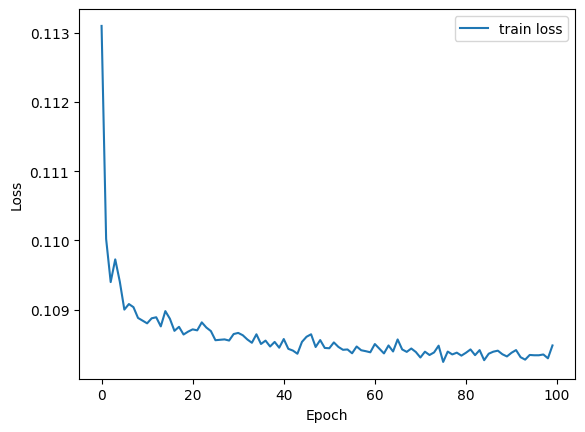

In [7]:
### Plot the loss
plt.plot(train_losses, label='train loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [8]:
model_v3_tanh.eval()
test_loss = 0.0
total_out = []

with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        outputs = model_v3_tanh(inputs.to(device))
        # print(outputs.size(), targets.size())
        loss = criterion(outputs[:,0,:], targets.to(device))
        test_loss += loss.item() * len(inputs)
        total_out.append(outputs)
        
test_loss /= len(test_data)
# model_v1.eval()
# with torch.no_grad():

#     predictions = model_v1(X_test_final.to(device))
#     print('Input:', X_test_final)
#     print('Predicted Output:', predictions)

In [9]:
final_out = torch.cat(total_out)
final_out[:,0,:].size()

torch.Size([1800, 249])

In [10]:
y_pre_trans = final_out[:,0,:].cpu().data.numpy()
scipy.io.savemat('./data_nature/transformer_v2_tanh.mat', {'modelv2_tanh_trans':y_pre_trans.T})

In [ ]:
scipy.io.savemat('./data_nature/test_transformer_v2_tanh.mat', {'test_modelv2_tanh_trans':y_test.T})